# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_varybatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix


cpu


'Jul28-1538'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    'contrastive',
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [6]:
"""
Single‑trajectory benchmark in which every *pair* of batches has the same
batch‑effect type at two different strengths (“low” / “high”).  This version
uses **option 2**: EFFECT_SPEC is a list of (effect_type, spec‑dict) tuples,
so you can repeat the same effect type with different parameterisations
(e.g. different noise distributions).
"""

import numpy as np
import anndata as ad
from concord.simulation import (
    Simulation,
    SimConfig, TrajectoryConfig, BatchConfig
)

# ───────────────────────── USER‑TUNABLES ──────────────────────────
TOTAL_CELLS   = 4_000        # overall cells (evenly split by default)
TOTAL_GENES   = 2_000
SEED_STATE    = 42
SEED_BATCH    = 4_242

# Two‑element “level” lists ⇒ [low, high]
EFFECT_SPEC = [
    ("variance_inflation",
        dict(level=[1, 4])),                             # multiplicative
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="normal")),
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="negative_binomial")),
    ("uniform_dropout",
        dict(level=[0.1, 0.4])),
    # ("value_dependent_dropout",
    #     dict(level=[0.01, 0.05])),
    ("downsampling",
        dict(level=[0.2, 0.8])),
    ("scaling_factor",
        dict(level=[0.5, 2.0])),
    ("batch_specific_expression",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
    ("batch_specific_features",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
]

traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 6.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.2,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)


# ─────────────── Build per‑batch parameter lists ──────────────────
n_effects  = len(EFFECT_SPEC)
rng        = np.random.default_rng(SEED_BATCH)

types, levels, dists, disps, f_fracs, cell_props, labels = (
    [], [], [], [], [], [], []
)

for eff, spec in EFFECT_SPEC:
    # two batches per effect type
    types.extend([eff, eff])

    # levels and other params
    lvl_low, lvl_high = spec.get("level", [None, None])
    levels.extend([lvl_low, lvl_high])

    dist = spec.get("distribution", "normal")
    dists.extend([dist, dist])

    disp = spec.get("dispersion", 2.0)
    disps.extend([disp, disp])

    ff = spec.get("feature_frac", 0.0)
    f_fracs.extend([ff, ff])

    # equal cell proportion by default
    cell_props.extend([1 / (2 * n_effects)] * 2)

    # human‑readable batch labels
    base = eff if eff != "batch_specific_distribution" else f"{eff}_{dist}"
    labels.extend([f"{base}_low", f"{base}_high"])

# ─────────────── Assemble BatchConfig ─────────────────────────────
batch_cfg = BatchConfig(
    n_batches       = len(types),
    effect_type     = types,
    distribution    = dists,
    level           = levels,
    dispersion      = disps,
    feature_frac    = f_fracs,
    cell_proportion = cell_props,
)

# ─────────────── Assemble SimConfig & run ────────────────────────
sim_cfg = SimConfig(
    n_cells = TOTAL_CELLS,
    n_genes = TOTAL_GENES,
    seed    = SEED_STATE,
    non_neg = True,
    to_int  = True,
)

sim = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()

# map descriptive labels to batches (order preserved)
adata.obs["batch_label"] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), labels))
)
adata.obs['batch_type'] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), types))
)

print(adata)


AnnData object with n_obs × n_vars = 4000 × 2400
    obs: 'time', 'batch', 'batch_id', 'batch_label', 'batch_type'
    layers: 'no_noise', 'wt_noise', 'counts'


In [7]:
import pandas as pd
pd.crosstab(adata.obs["batch_label"], adata.obs["batch_type"])

batch_type                                          batch_specific_distribution  \
batch_label                                                                       
batch_specific_distribution_negative_binomial_high                          250   
batch_specific_distribution_negative_binomial_low                           250   
batch_specific_distribution_normal_high                                     250   
batch_specific_distribution_normal_low                                      250   
batch_specific_expression_high                                                0   
batch_specific_expression_low                                                 0   
batch_specific_features_high                                                  0   
batch_specific_features_low                                                   0   
downsampling_high                                                             0   
downsampling_low                                                              0   
scaling_factor_high                                                           0   
scaling_factor_low                                                            0   
uniform_dropout_high                                                          0   
uniform_dropout_low                                                           0   
variance_inflation_high                                                       0   
variance_inflation_low                                                        0   

batch_type                                          batch_specific_expression  \
batch_label                                                                     
batch_specific_distribution_negative_binomial_high                          0   
batch_specific_distribution_negative_binomial_low                           0   
batch_specific_distribution_normal_high                                     0   
batch_specific_distribution_normal_low                                      0   
batch_specific_expression_high                                            250   
batch_specific_expression_low                                             250   
batch_specific_features_high                                                0   
batch_specific_features_low                                                 0   
downsampling_high                                                           0   
downsampling_low                                                            0   
scaling_factor_high                                                         0   
scaling_factor_low                                                          0   
uniform_dropout_high                                                        0   
uniform_dropout_low                                                         0   
variance_inflation_high                                                     0   
variance_inflation_low                                                      0   

batch_type                                          batch_specific_features  \
batch_label                                                                   
batch_specific_distribution_negative_binomial_high                        0   
batch_specific_distribution_negative_binomial_low                         0   
batch_specific_distribution_normal_high                                   0   
batch_specific_distribution_normal_low                                    0   
batch_specific_expression_high                                            0   
batch_specific_expression_low                                             0   
batch_specific_features_high                                            250   
batch_specific_features_low                                             250   
downsampling_high                                                         0   
downsampling_low                                                          0   
scaling_factor_high                                                       0   
scaling_factor_low 

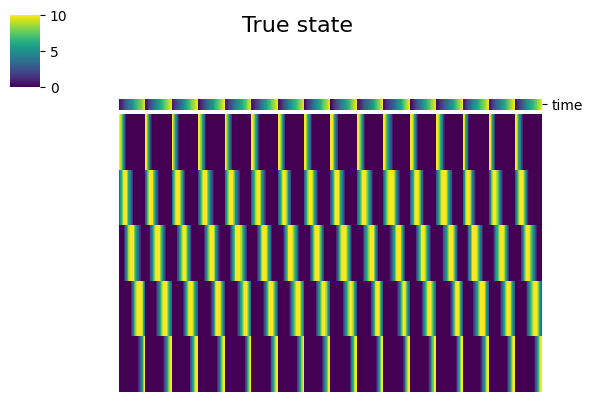

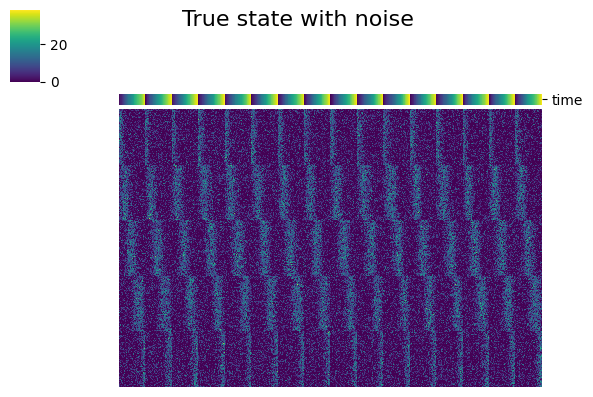

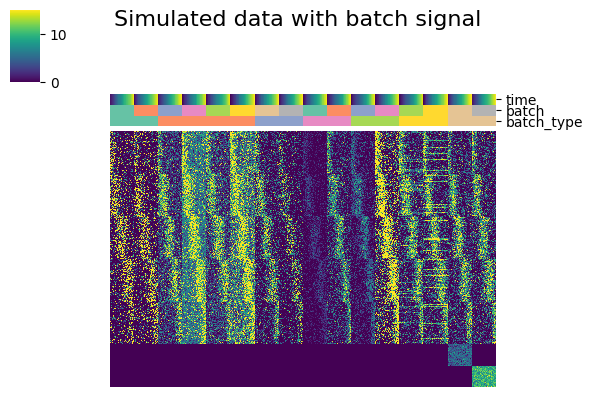

In [8]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key, 'batch_type'], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

## Integration pipeline

In [9]:
run_methods = concord_methods + other_methods
latent_dim = 30

In [10]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']

concord - INFO - PCA performed on source data with 30 components
concord - INFO - PCA embedding stored in adata.obsm['no_noise_PCA']
concord - INFO - PCA performed on source data with 30 components
concord - INFO - PCA embedding stored in adata.obsm['wt_noise_PCA']


In [11]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'load_data_into_memory': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 11.33s | 84.78 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 8.80s | 1.20 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skippin

contrastive: 8.99s | 0.19 MB RAM | 0.00 MB VRAM
Running PCA for 'unintegrated' embedding …


Found 2400 genes among all datasets


scanorama: 0.86s | 190.48 MB RAM | 0.00 MB VRAM


[[0.    0.004 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

100%|██████████| 30/30 [02:47<00:00,  5.58s/it]
liger: 173.66s | 1073.38 MB RAM | 0.00 MB VRAM


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


harmony: 5.03s | 0.00 MB RAM | 0.00 MB VRAM
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 204.42s | 99.98 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [12]:
for basis in combined_keys:
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=seed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Running UMAP for no_noise
Running UMAP for wt_noise
Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive
Running UMAP for unintegrated
Running UMAP for scanorama
Running UMAP for liger
Running UMAP for harmony
Running UMAP for scvi


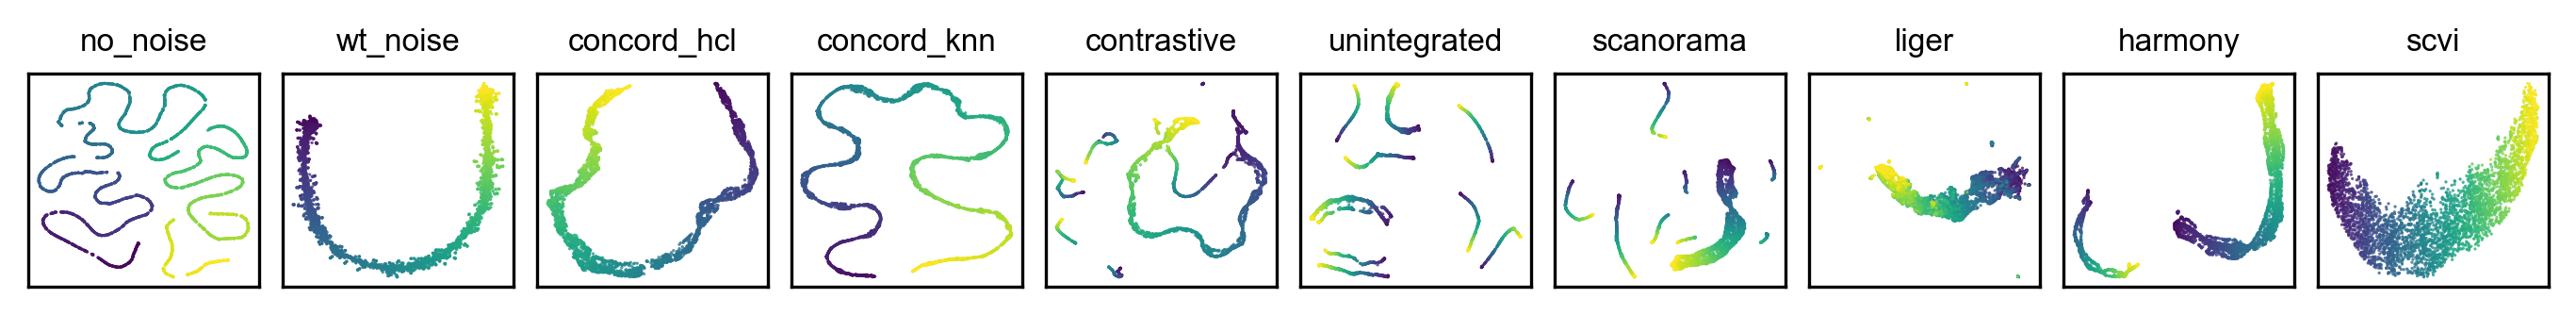

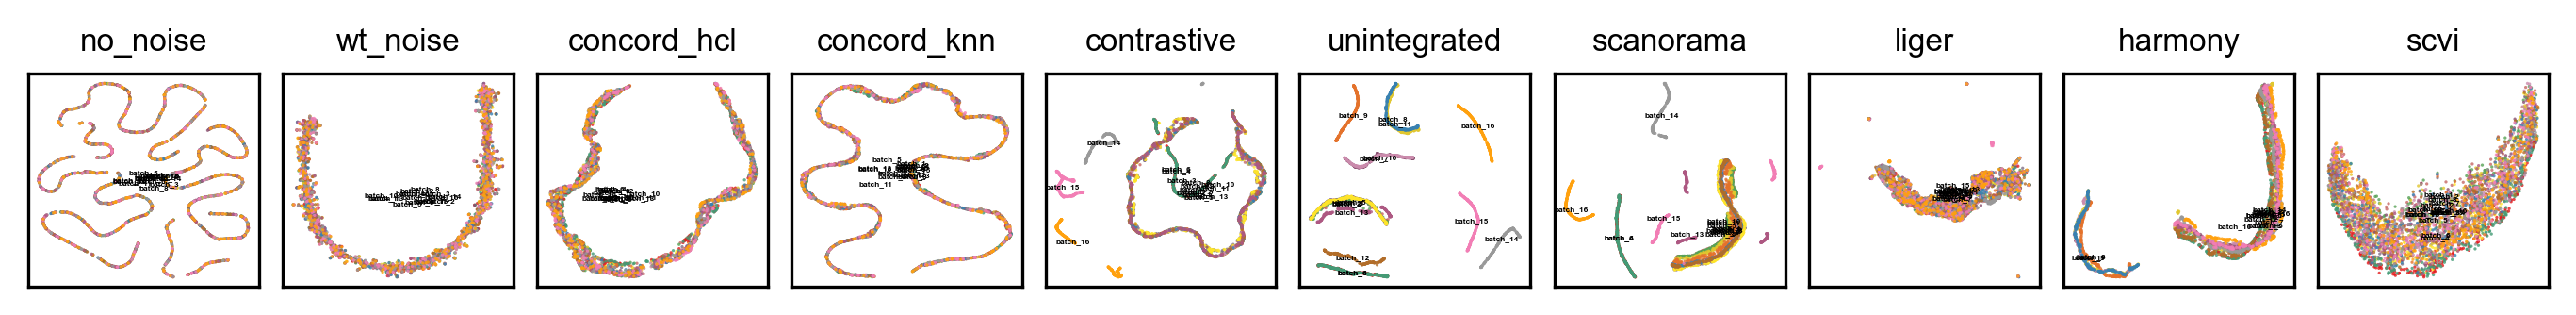

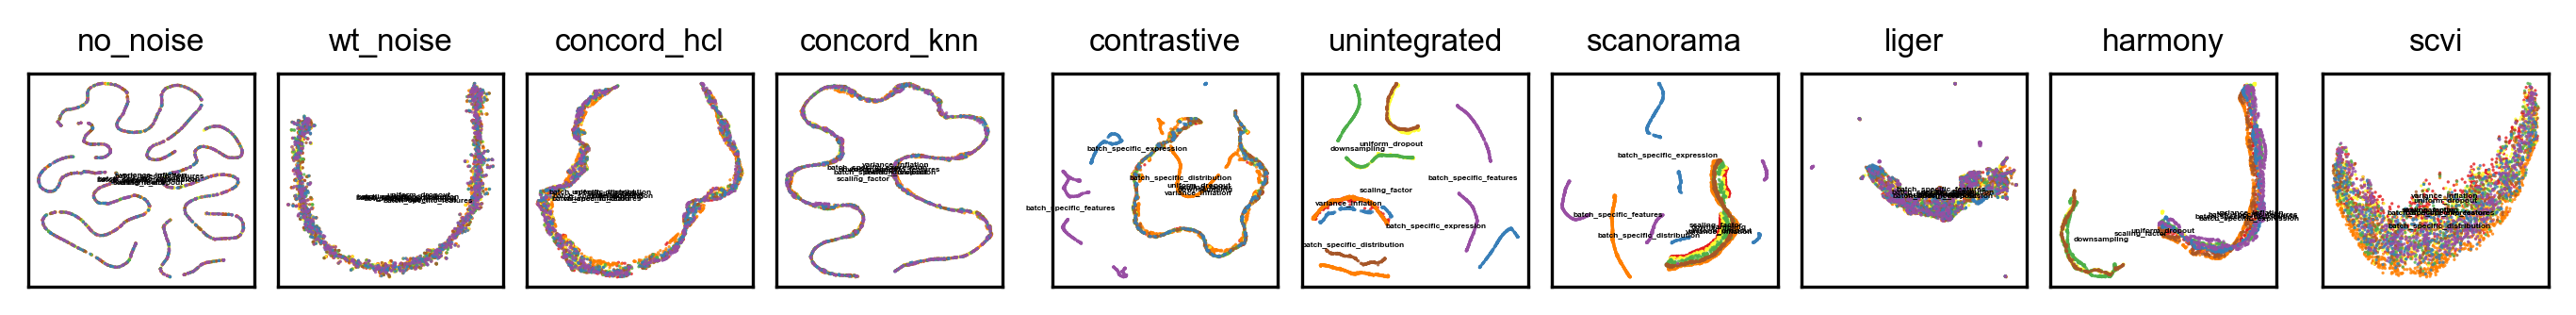

In [13]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key in adata.obsm.keys()]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch', 'batch_type']
basis_types = ['UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+2,
        leiden_key='leiden',
        save_dir=save_dir,
        legend_loc = 'on data',
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [14]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory_varybatch/adata_Jul28-1318.h5ad
Saved adata_state to ../data/simulation_trajectory_varybatch/adata_state_Jul28-1318.h5ad


### Benchmark

In [6]:
adata = sc.read(data_dir / f"adata_Jul28-1318.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul28-1318.h5ad")

In [7]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='no_noise_PCA', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - Running SCIB benchmark


Embeddings: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


concord - INFO - Running Probe benchmark
concord - INFO - Running linear probe for state with keys ['no_noise', 'wt_noise', 'concord_hcl', 'concord_knn', 'contrastive', 'unintegrated', 'scanorama', 'liger', 'harmony', 'scvi']
Detected task: classification
concord - INFO - Running k-NN probe for state with keys ['no_noise', 'wt_noise', 'concord_hcl', 'concord_knn', 'contrastive', 'unintegrated', 'scanorama', 'liger', 'harmony', 'scvi']
[KNN] detected task: classification
concord - INFO - Running Topology benchmark
concord - INFO - Computing persistent homology for no_noise
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology for wt_noise
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology for concord_hcl
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology fo

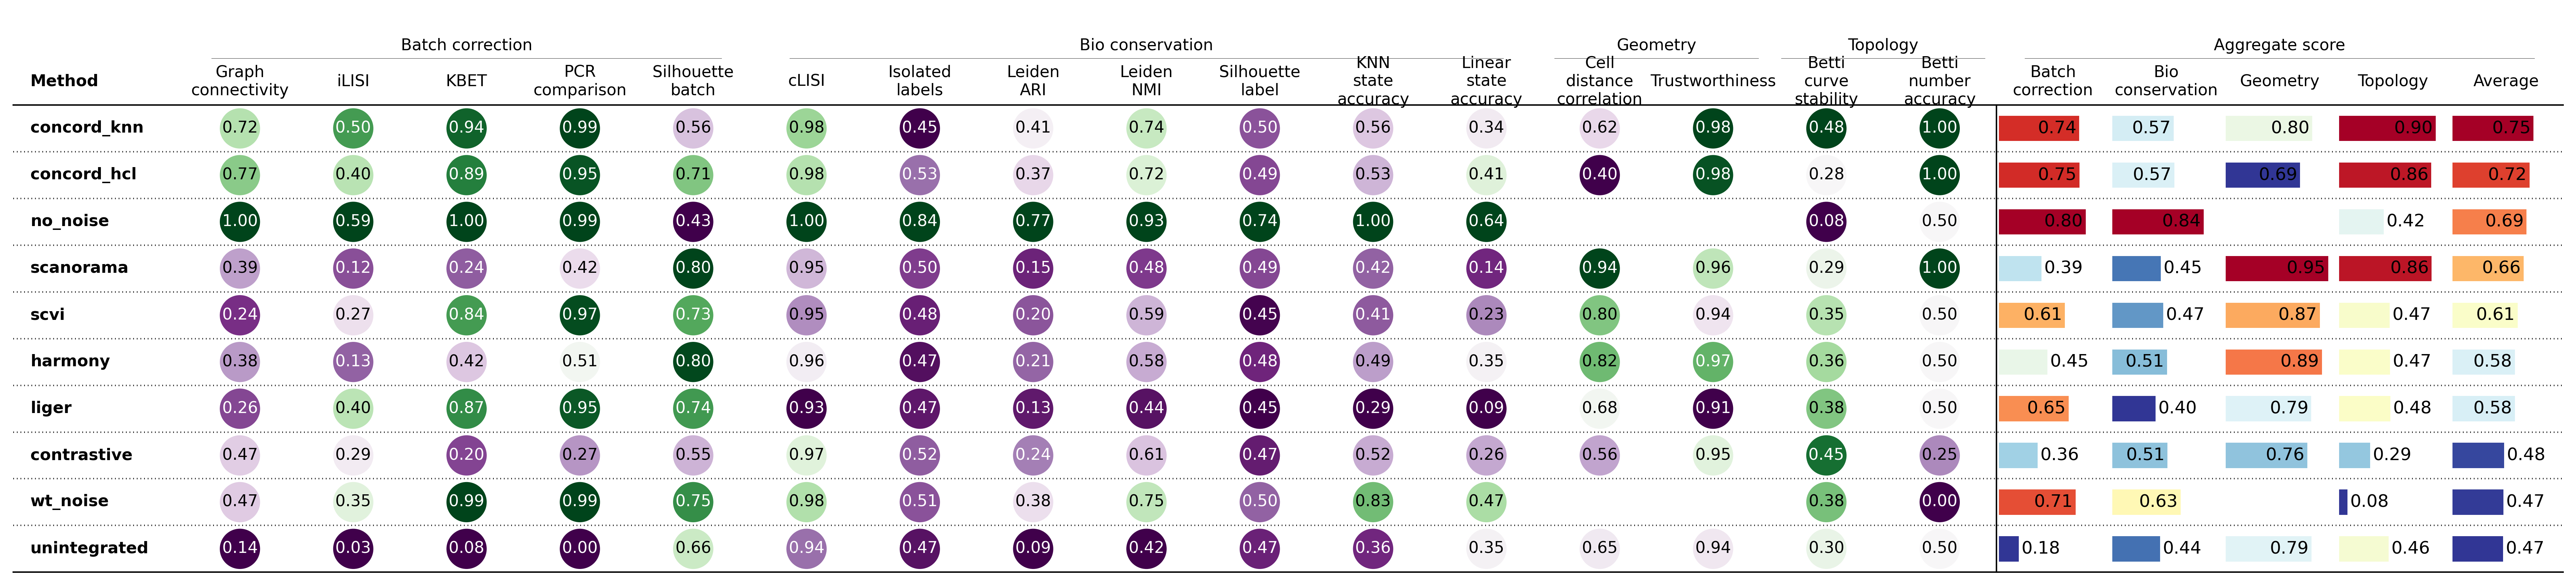

concord - INFO - Saved benchmark results to ../save/dev_simulation_trajectory_varybatch-Jul28/benchmarks_out/benchmark_results_Jul28-1318.pkl


Batch correction                                     \
            Graph connectivity     iLISI      KBET PCR comparison   
concord_knn           0.718639  0.500013  0.942809        0.98856   
concord_hcl            0.77398  0.402438  0.890139       0.954508   
no_noise                   1.0  0.594448  0.997468       0.986002   
scanorama             0.391445   0.11506  0.237597       0.420505   
scvi                  0.236956  0.273936  0.843074       0.970724   

                             Bio conservation                             \
            Silhouette batch            cLISI Isolated labels Leiden ARI   
concord_knn         0.564843         0.978712        0.451088   0.414454   
concord_hcl         0.706164         0.975593        0.529889   0.366494   
no_noise            0.432876         0.999373        0.839897   0.771831   
scanorama           0.798987         0.951597        0.499722   0.145925   
scvi                0.730103         0.945557        0.480198   0.199199   

                                         ...                        \
            Leiden NMI Silhouette label  ... Linear state accuracy   
concord_knn   0.743364         0.496548  ...               0.34250   
concord_hcl    0.72068         0.492536  ...               0.40500   
no_noise      0.927697         0.743614  ...               0.63500   
scanorama     0.483334          0.49222  ...               0.13875   
scvi          0.589111         0.452774  ...               0.22500   

                             Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
concord_knn                  0.620682        0.984335              0.478792   
concord_hcl                  0.397435        0.982116              0.277454   
no_noise                          NaN             NaN              0.079061   
scanorama                    0.940625        0.957337              0.293653   
scvi                         0.803470        0.941824              0.346055   

                                   Aggregate score                             \
            Betti number accuracy Batch correction Bio conservation  Geometry   
concord_knn                   1.0         0.742973         0.568809  0.802509   
concord_hcl                   1.0         0.745446         0.573777  0.689776   
no_noise                      0.5         0.802159         0.844809       NaN   
scanorama                     1.0         0.392719         0.447542  0.948981   
scvi                          0.5         0.610959         0.472048  0.872647   

                                 
             Topology   Average  
concord_knn  0.895758  0.752512  
concord_hcl  0.855491  0.716122  
no_noise     0.415812  0.687593  
scanorama    0.858731  0.661993  
scvi         0.469211  0.606216  

[5 rows x 21 columns]

In [16]:
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=leiden_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers=[0,0,0],  # expected Betti numbers for the geometry and topology blocks
    max_points=1000,
    verbose=True,
    seed=seed,  # for reproducibility
)
combined = out["combined"]
combined.head()

In [17]:
import pickle
out = pickle.load(open(Path("../save/dev_simulation_trajectory_varybatch-Jul28/benchmarks_out") / f"benchmark_results_Jul28-1318.pkl", "rb"))
combined = out["combined"]

with open('../save/dev_simulation_trajectory_varybatch-Jul28/benchmarks_out/topology_diagrams_Jul28-1318.pkl', 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open(Path("../save/dev_simulation_trajectory_varybatch-Jul28/benchmarks_out/geometry_results_Jul28-1318.pkl"), "rb"))


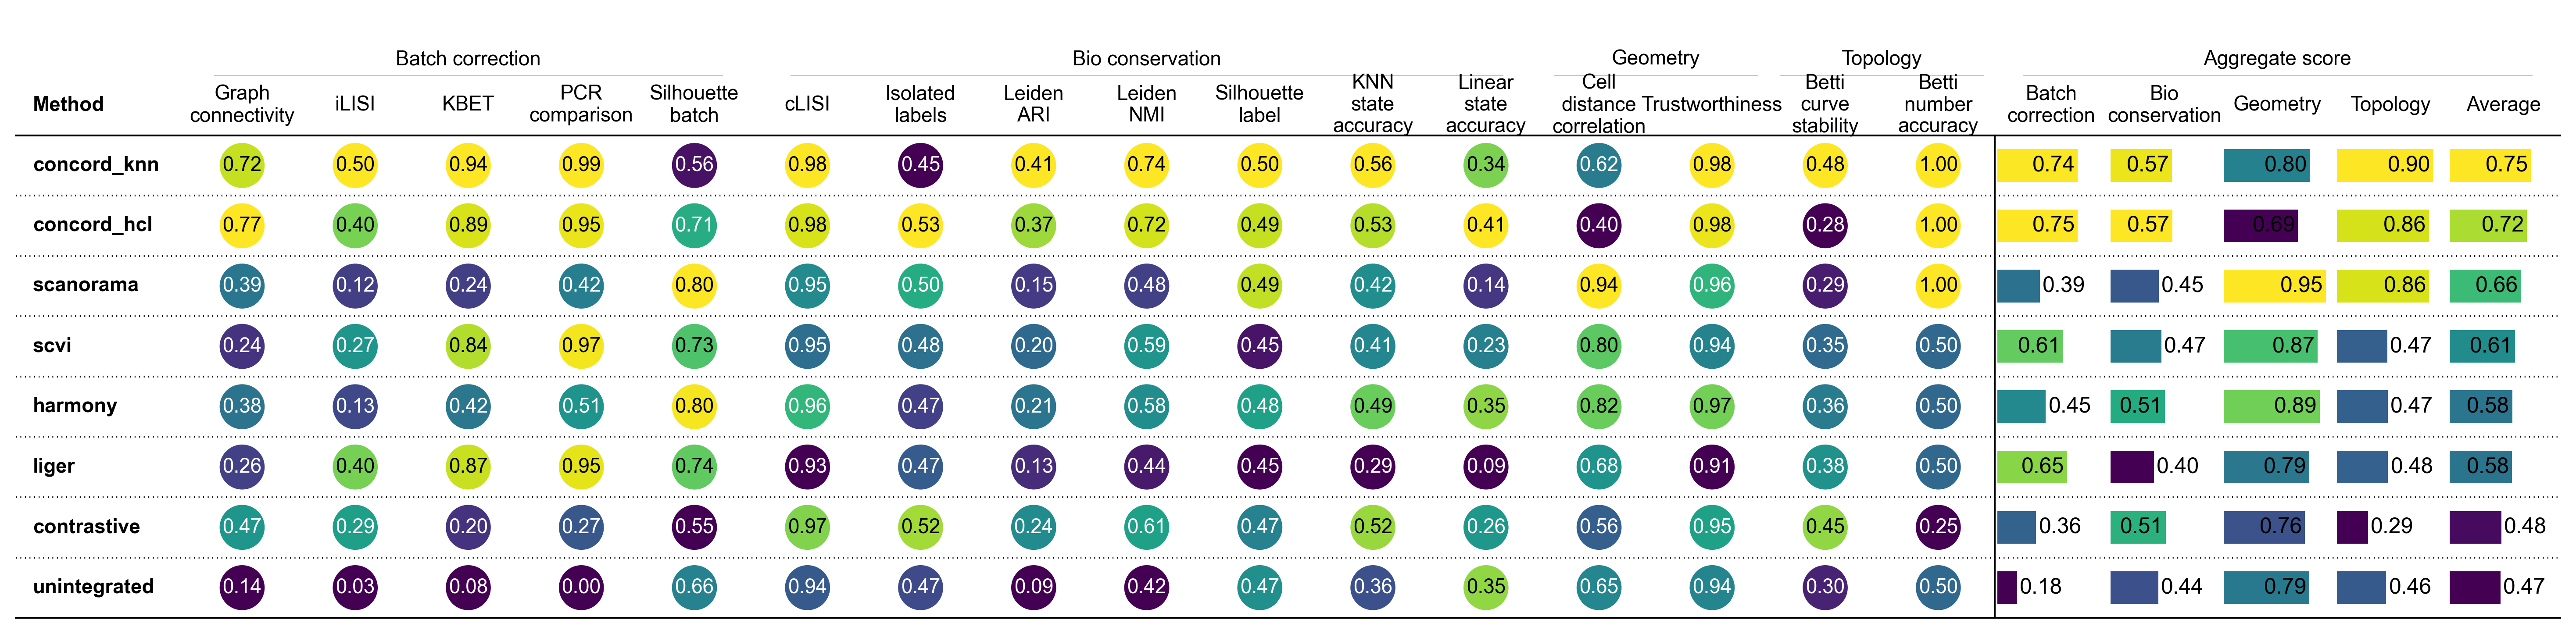

In [18]:
import pickle
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results(
        out,
        block_include=("geometry", "topology", "scib", "probe"),
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 6),
            **table_plot_kw
            )

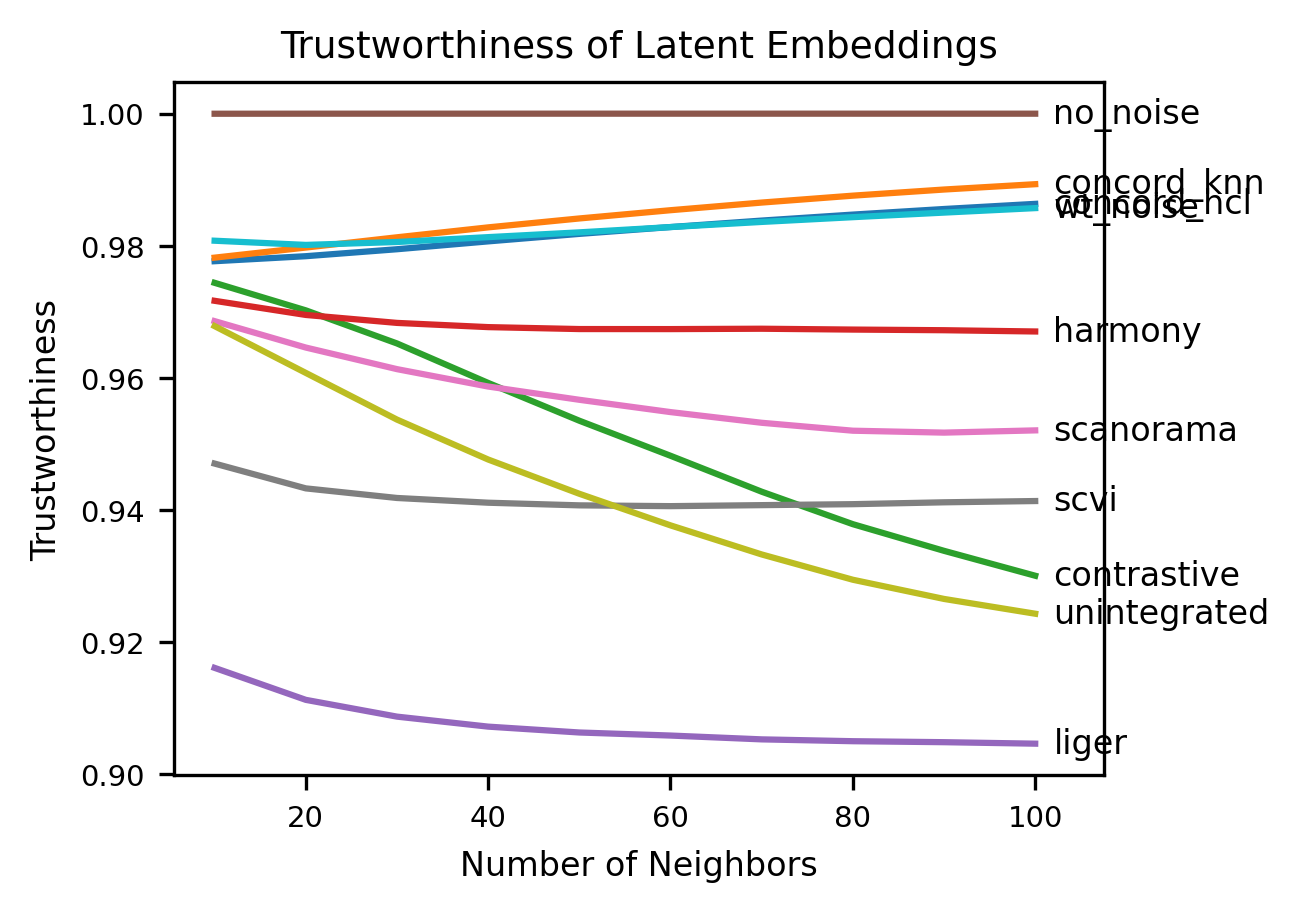

In [21]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, min_gap=0.0005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(4,3))

### Performance on unseen batch effects

In [ ]:
#adata = sc.read(data_dir / f"adata_Jul28-1318.h5ad")
adata = sc.read(data_dir / f"adata_Jul28-1538.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul28-1318.h5ad")

In [101]:
import itertools, random, pathlib, pandas as pd, numpy as np, scanpy as sc

# ----- experiment knobs ------------------------------------------------
BATCH_KEY      = "batch"
LEIDEN_KEY     = "leiden_no_noise"
MAX_R          = 5               # replicates per k
SAVE_DIR       = save_dir / "model_ckpts"
SAVE_DIR.mkdir(exist_ok=True, parents=True)
LATENT_DIM    = 30


def train_concord(adata_train, *, out_key, model_dir, mode, seed):
    concord_kwargs = {
        'batch_size': 32,
        'n_epochs': 20,
        'load_data_into_memory': True,
        'verbose': False,
    }
    if mode == 'hcl':
        concord_kwargs.update({
            'clr_beta': 1.0,
            'p_intra_knn': 0.0,
        })
    elif mode == 'knn':
        concord_kwargs.update({
            'clr_beta': 0.0,
            'p_intra_knn': 0.3,
        })
    else:
        raise ValueError(f"Unknown mode: {mode}")

    model = ccd.Concord(
        adata=adata_train, 
        latent_dim=LATENT_DIM,  # specify latent dimension
        domain_key=BATCH_KEY,
        seed=seed, save_dir=model_dir, 
        **concord_kwargs
    )
    model.fit_transform(output_key=out_key)
    return model          # keep for .predict_adata()

def train_scvi_reference(adata_ref, *, model_dir, seed, latent_key="scvi_latent"):
    """
    Train an SCVI model on `adata_ref`, save it to `model_dir`,
    and write the reference latent to `adata_ref.obsm[latent_key]`.
    """
    import scvi
    scvi.model.SCVI.setup_anndata(adata_ref, batch_key=BATCH_KEY)
    vae = scvi.model.SCVI(adata_ref, n_latent=LATENT_DIM)
    vae.train()
    vae.save(model_dir, overwrite=True)                # <--- saves weights + registry
    adata_ref.obsm[latent_key] = vae.get_latent_representation()
    return model_dir   

def embed_scvi_query(adata_query, *, model_dir, latent_key="scvi_latent"):
    """
    Given trained model at `model_dir`, project `adata_query`
    into the same latent space and write to `adata_query.obsm[latent_key]`.
    """
    import scvi
    # 1) register the query AnnData with the reference registry
    scvi.model.SCVI.prepare_query_anndata(adata_query, str(model_dir))

    # 2) create a *new* model tied to that query AnnData
    vae_q = scvi.model.SCVI.load_query_data(adata_query, str(model_dir))
    vae_q.is_trained = True                             # skip further training

    # 3) obtain latent representation
    adata_query.obsm[latent_key] = vae_q.get_latent_representation()


# ----- outer loop ------------------------------------------------------
all_batches = sorted(adata.obs[BATCH_KEY].unique())
N      = len(all_batches)

for k in range(1, N, 3):                          # number of training batches
    subsets = list(itertools.combinations(all_batches, k))
    random.Random(0).shuffle(subsets)          # reproducible
    for rep, train_batches in enumerate(subsets[:MAX_R]):
        test_batches = [b for b in all_batches if b not in train_batches]

        # split AnnData
        mask_train = adata.obs[BATCH_KEY].isin(train_batches)
        ad_train   = adata[mask_train].copy()
        ad_test    = adata[~mask_train].copy()

        print(f"Running k={k}, rep={rep+1}/{len(subsets[:MAX_R])} "
              f"({len(train_batches)} train, {len(test_batches)} test batches)")

        # ---------- CONCORD hcl ------------------------------------------
        # run_id = f"concord_hcl_k{k}_rep{rep}"
        # print(f"Running CONCORD with run_id={run_id}")
        # ckpt_dir = SAVE_DIR / run_id
        # ckpt_dir.mkdir(parents=True, exist_ok=True)

        # model_c  = train_concord(ad_train, out_key="concord_hcl", mode="hcl",
        #                          model_dir=ckpt_dir, seed=10_000 * k + rep)
        # model_c.predict_adata(ad_test, output_key="concord_hcl")

        # ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
        #                                  index_unique=None)
        
        # # Append the embeddings to the original AnnData
        # ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        # adata.obsm[run_id] = ad_merge.obsm["concord_hcl"]

        # ---------- CONCORD knn ------------------------------------------
        run_id = f"concord_knn_k{k}_rep{rep}"
        print(f"Running CONCORD with run_id={run_id}")
        ckpt_dir = SAVE_DIR / run_id
        ckpt_dir.mkdir(parents=True, exist_ok=True)

        model_c  = train_concord(ad_train, out_key="concord_knn", mode="knn",
                                 model_dir=ckpt_dir, seed=10_000 * k + rep)
        model_c.predict_adata(ad_test, output_key="concord_knn")

        ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
                                         index_unique=None)
        
        # Append the embeddings to the original AnnData
        ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        adata.obsm[run_id] = ad_merge.obsm["concord_knn"]

        # ---------- scVI ----------------------------------
        # run_id     = f"scvi_k{k}_rep{rep}"
        # model_dir  = SAVE_DIR / run_id
        # model_dir.mkdir(exist_ok=True, parents=True)

        # # train on reference batches
        # train_scvi_reference(ad_train, model_dir=model_dir,
        #                      seed=10_000 * k + rep,
        #                      latent_key="scVI")

        # # embed held‑out batches as query
        # embed_scvi_query(ad_test, model_dir=model_dir,
        #                  latent_key="scVI")

        # # merge & score
        # ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
        #                                 index_unique=None)
        # ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        # adata.obsm[run_id] = ad_merge.obsm["scVI"]



        adata.obs[f'Set_k{k}_rep{rep}'] = ad_merge.obs["train_test_set"]



Running k=1, rep=1/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_knn_k1_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - domain/batch information not found, all sample

In [94]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='no_noise_PCA', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

In [103]:
# Get run ids from adata.obsm, any key that starts with 'concord_hcl_k' or 'scvi_k', but not contain 'UMAP' or 'PCA'
run_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_hcl_k') or key.startswith('concord_knn_k') or key.startswith('scvi_k')) and 'UMAP' not in key and 'PCA' not in key]
bm_results = ccd.bm.run_probe_benchmark(
        adata, embedding_keys=run_ids, state_key=LEIDEN_KEY,
        batch_key=BATCH_KEY, plot=False, verbose=True,
    )

concord - INFO - Running linear probe for state with keys ['concord_hcl_k10_rep0', 'concord_hcl_k10_rep1', 'concord_hcl_k10_rep2', 'concord_hcl_k10_rep3', 'concord_hcl_k10_rep4', 'concord_hcl_k13_rep0', 'concord_hcl_k13_rep1', 'concord_hcl_k13_rep2', 'concord_hcl_k13_rep3', 'concord_hcl_k13_rep4', 'concord_hcl_k1_rep0', 'concord_hcl_k1_rep1', 'concord_hcl_k1_rep2', 'concord_hcl_k1_rep3', 'concord_hcl_k1_rep4', 'concord_hcl_k4_rep0', 'concord_hcl_k4_rep1', 'concord_hcl_k4_rep2', 'concord_hcl_k4_rep3', 'concord_hcl_k4_rep4', 'concord_hcl_k7_rep0', 'concord_hcl_k7_rep1', 'concord_hcl_k7_rep2', 'concord_hcl_k7_rep3', 'concord_hcl_k7_rep4', 'scvi_k10_rep0', 'scvi_k10_rep1', 'scvi_k10_rep2', 'scvi_k10_rep3', 'scvi_k10_rep4', 'scvi_k13_rep0', 'scvi_k13_rep1', 'scvi_k13_rep2', 'scvi_k13_rep3', 'scvi_k13_rep4', 'scvi_k1_rep0', 'scvi_k1_rep1', 'scvi_k1_rep2', 'scvi_k1_rep3', 'scvi_k1_rep4', 'scvi_k4_rep0', 'scvi_k4_rep1', 'scvi_k4_rep2', 'scvi_k4_rep3', 'scvi_k4_rep4', 'scvi_k7_rep0', 'scvi_k7_r

In [104]:
bm_results

KNN                       Linear  \
                     batch\nerror state\naccuracy batch\nerror   
Method                                                           
concord_knn_k13_rep0      0.88250         0.55625      0.95000   
concord_hcl_k10_rep1      0.86000         0.59125      0.88000   
concord_knn_k10_rep3      0.91125         0.56250      0.93000   
concord_knn_k13_rep2      0.87125         0.57125      0.92875   
concord_knn_k10_rep1      0.87500         0.58375      0.93375   
...                           ...             ...          ...   
scvi_k1_rep0              0.61875         0.39250      0.72875   
scvi_k7_rep0              0.72250         0.36875      0.63000   
scvi_k4_rep2              0.65625         0.39250      0.63375   
scvi_k4_rep4              0.50875         0.43125      0.68750   
scvi_k4_rep3              0.62375         0.37875      0.64125   

                                         Probe  
                     state\naccuracy     Score  
Method                                          
concord_knn_k13_rep0         0.38125  0.692500  
concord_hcl_k10_rep1         0.43625  0.691875  
concord_knn_k10_rep3         0.36000  0.690937  
concord_knn_k13_rep2         0.38250  0.688437  
concord_knn_k10_rep1         0.34625  0.684688  
...                              ...       ...  
scvi_k1_rep0                 0.31000  0.512500  
scvi_k7_rep0                 0.29125  0.503125  
scvi_k4_rep2                 0.29125  0.493438  
scvi_k4_rep4                 0.33875  0.491563  
scvi_k4_rep3                 0.31250  0.489062  

[75 rows x 5 columns]

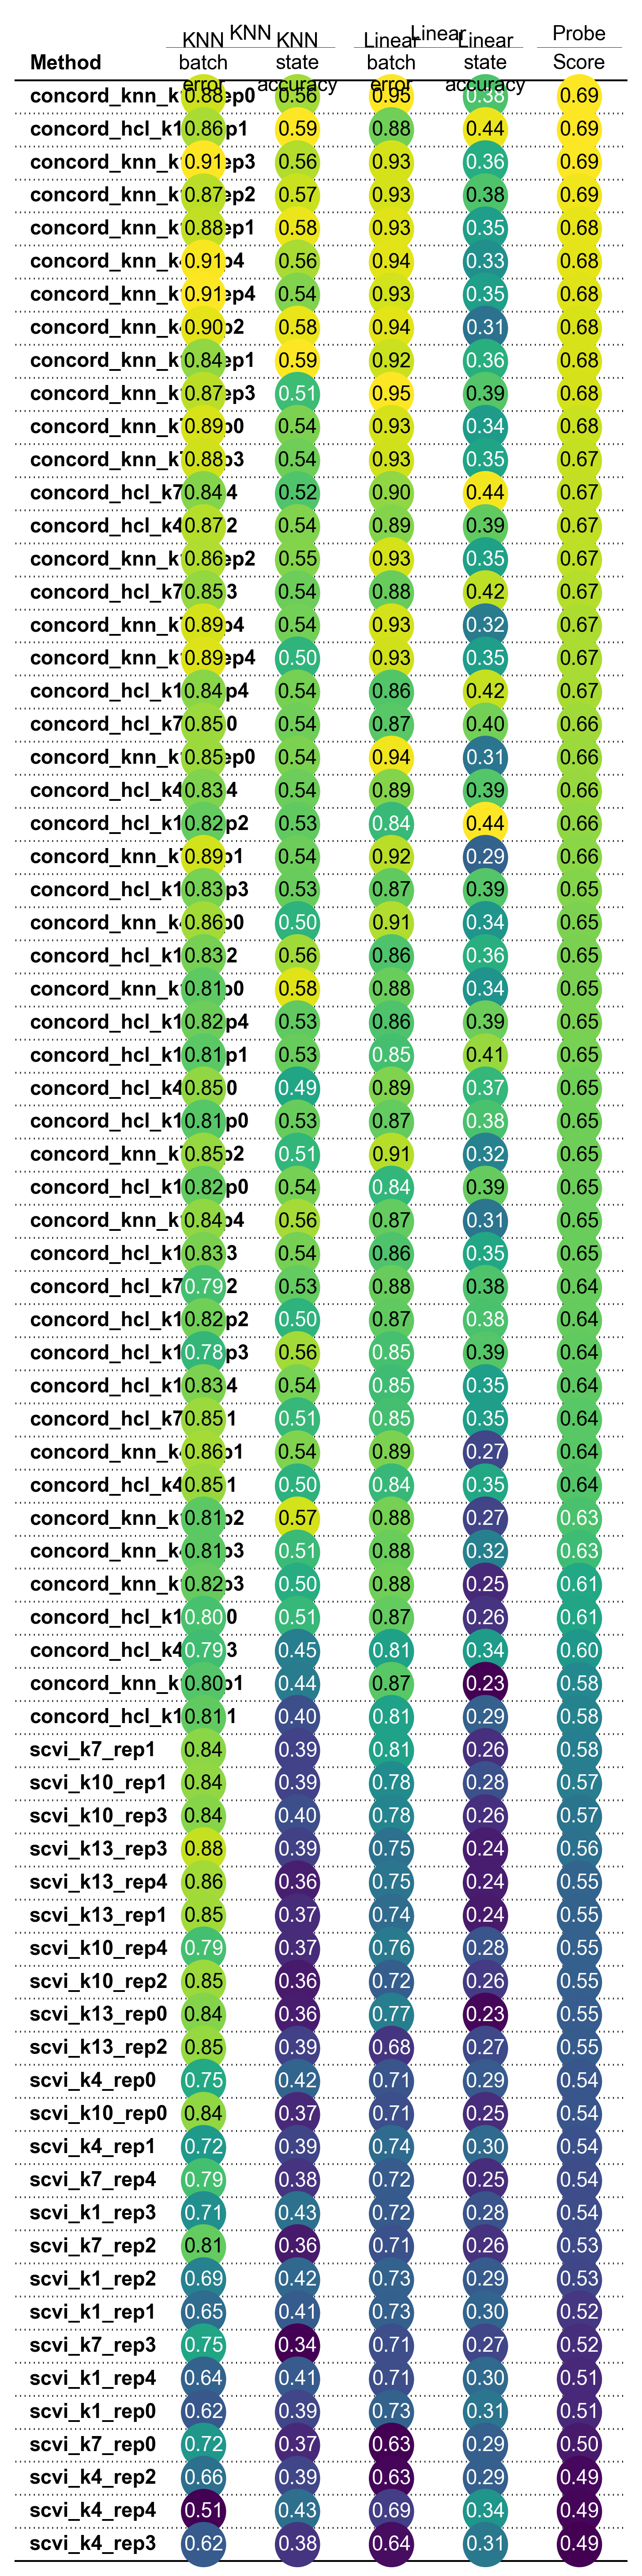

In [105]:
import pickle
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    ccd.bm.plot_benchmark_table(
            bm_results.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_results_predictunseen_{file_suffix}.svg",
            agg_name="Probe score",
            figsize=(6, 25),
            **table_plot_kw
            )

In [ ]:
hcl_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_hcl_k')) and 'UMAP' not in key and 'PCA' not in key]
knn_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_knn_k')) and 'UMAP' not in key and 'PCA' not in key]
scvi_ids = [key for key in adata.obsm.keys() if (key.startswith('scvi_k')) and 'UMAP' not in key and 'PCA' not in key]\

In [109]:
for basis in knn_ids:
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=seed)

Running UMAP for concord_knn_k1_rep0
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep0_UMAP']
Running UMAP for concord_knn_k1_rep1
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep1_UMAP']
Running UMAP for concord_knn_k1_rep2
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep2_UMAP']
Running UMAP for concord_knn_k1_rep3
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep3_UMAP']
Running UMAP for concord_knn_k1_rep4
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep4_UMAP']
Running UMAP for concord_knn_k4_rep0
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep0_UMAP']
Running UMAP for concord_knn_k4_rep1
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep1_UMAP']
Running UMAP for concord_knn_k4_rep2
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep2_UMAP']
Running UMAP for concord_knn_k4_rep3
concord - INFO - UM

In [141]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory_varybatch/adata_Jul28-1538.h5ad


In [89]:
adata = sc.read(data_dir / f"adata_Jul28-1538.h5ad")

concord.plotting.pl_embedding - INFO - Plotting concord_knn_k1_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k4_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k7_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k10_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k13_rep1 with time in UMAP


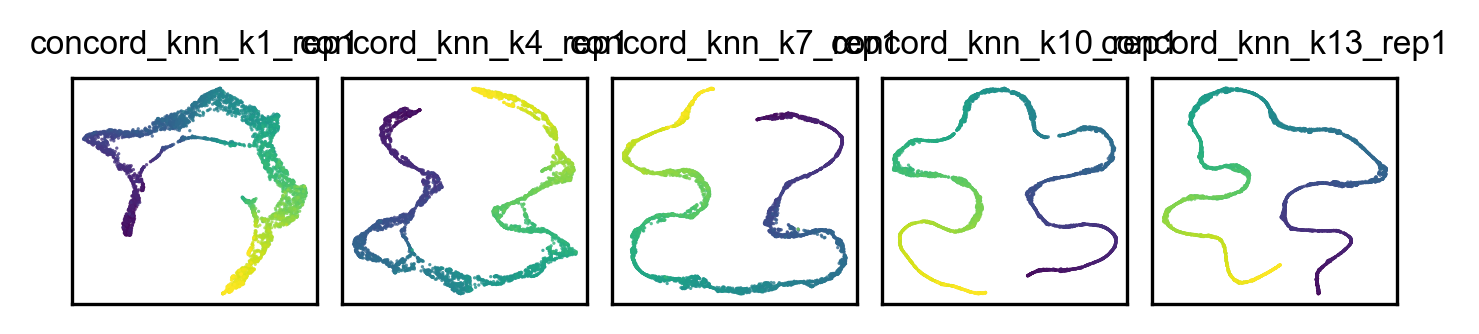

concord.plotting.pl_embedding - INFO - Plotting concord_knn_k1_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k4_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k7_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k10_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k13_rep1 with batch in UMAP


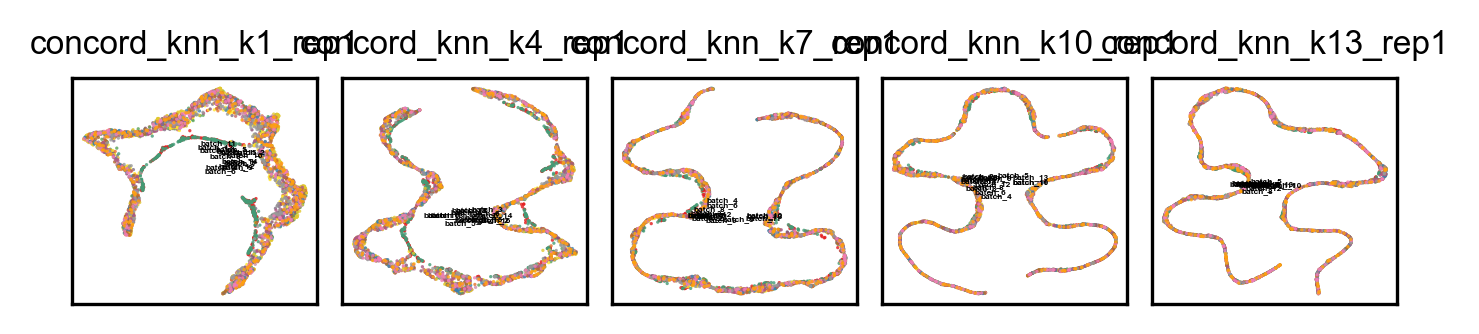

concord.plotting.pl_embedding - INFO - Plotting concord_knn_k1_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k4_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k7_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k10_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn_k13_rep1 with batch_type in UMAP


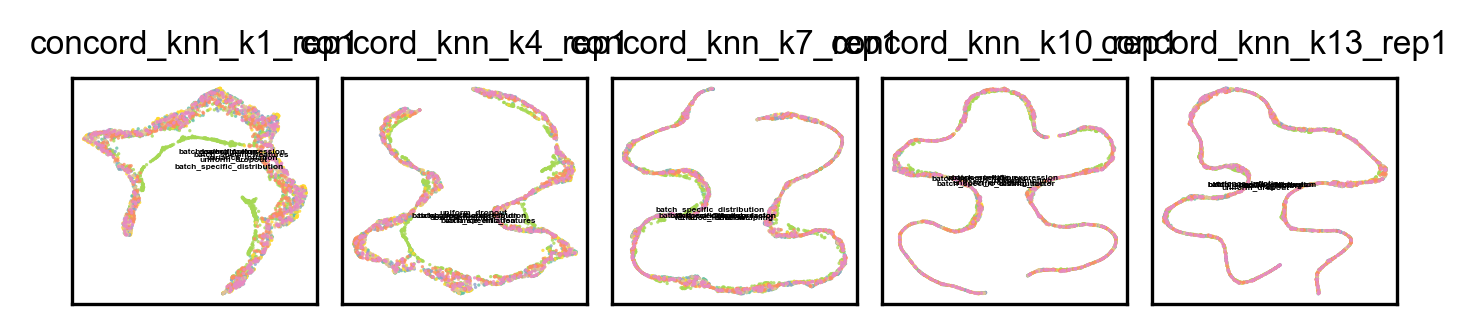

In [123]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in knn_ids if 'rep1' in key]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch', 'batch_type']
basis_types = ['UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1', 'batch_type':'Set2'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+2,
        leiden_key='leiden',
        save_dir=save_dir,
        legend_loc = 'on data',
        file_suffix=file_suffix+f'concord_results',
        save_format='svg'
    )


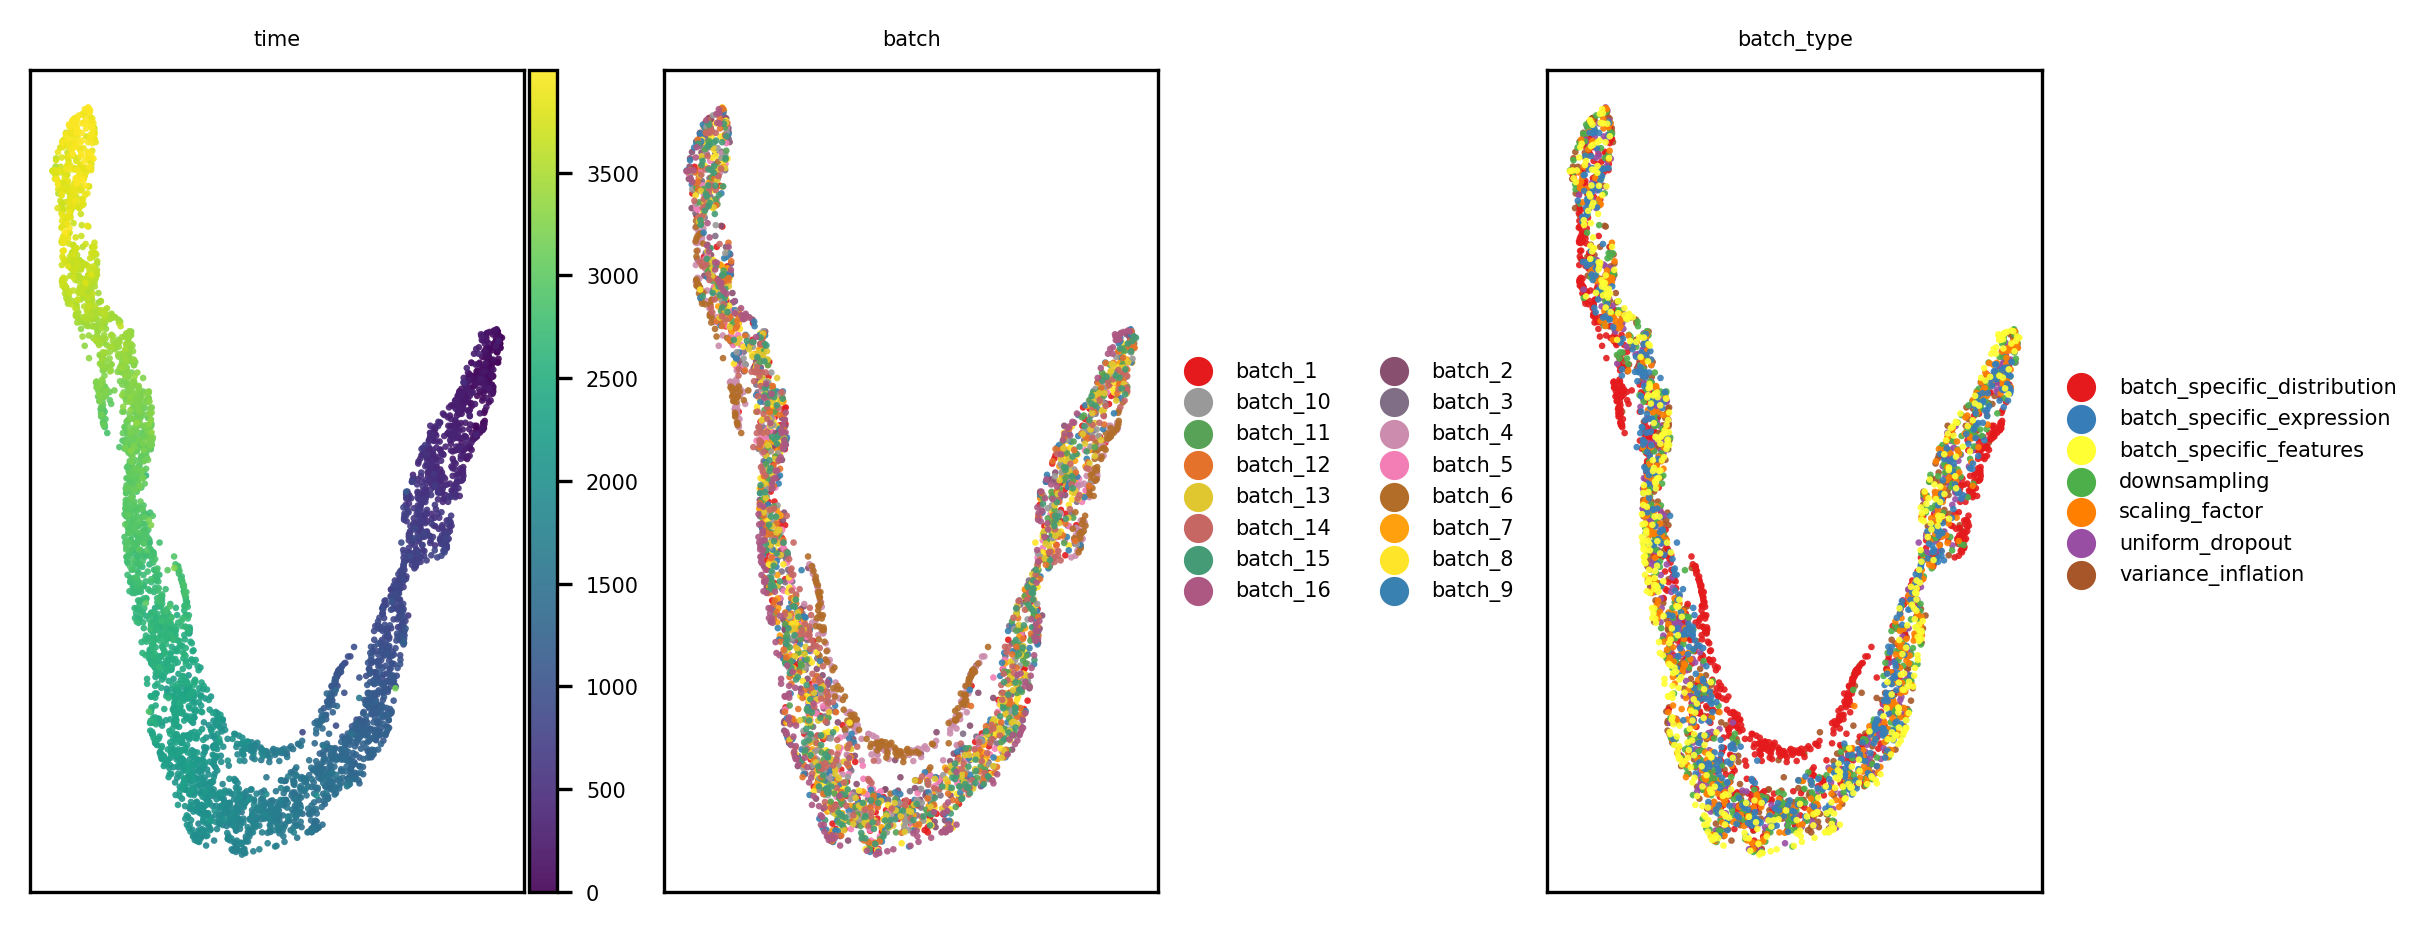

In [ ]:
show_cols = [state_key, batch_key, 'batch_type']
show_basis = 'concord_hcl_k4_rep3_UMAP'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='right margin',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [129]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
# 0.  basic info                                                     #
# ------------------------------------------------------------------ #
BATCH_KEY        = "batch"                 # whatever you used earlier
total_batches    = adata.obs[BATCH_KEY].nunique()   # == N in the loop

# ------------------------------------------------------------------ #
# 1.  flatten the MultiIndex columns                                 #
# ------------------------------------------------------------------ #
flat = bm_results.copy()

flat.columns = (
    flat.columns.to_flat_index()           # e.g. ('KNN', 'batch\nerror')
        .map(lambda tup:
             "_".join(
                 str(x).strip().lower().replace("\n", " ")
                      .replace("  ", " ").replace(" ", "_")
                 for x in tup if x)        # drop empty level labels
        )
)

# after the call you'll have columns such as:
#   knn_batch_error, knn_state_accuracy,
#   linear_batch_error, linear_state_accuracy,
#   probe_state_accuracy, probe_score

# ------------------------------------------------------------------ #
# 2.  move run‑id (index) to a column & parse it                     #
# ------------------------------------------------------------------ #
flat = flat.reset_index().rename(columns={"Method": "run_id"})

# run_id pattern: <model>_k<k>_rep<rep>
m = flat["run_id"].str.extract(
        r"(?P<model>concord_hcl|concord_knn|scvi)_k(?P<k>\d+)_rep(?P<rep>\d+)"
    )
flat = pd.concat([flat, m.astype({"k": int, "rep": int})], axis=1)

# ------------------------------------------------------------------ #
# 3.  add training / held‑out info                                   #
# ------------------------------------------------------------------ #
flat["train_batches"] = flat["k"]
flat["test_batches"]  = total_batches - flat["k"]
flat["frac_dropped"]  = flat["test_batches"] / total_batches
flat

run_id  knn_batch_error  knn_state_accuracy  \
0   concord_knn_k13_rep0          0.88250             0.55625   
1   concord_hcl_k10_rep1          0.86000             0.59125   
2   concord_knn_k10_rep3          0.91125             0.56250   
3   concord_knn_k13_rep2          0.87125             0.57125   
4   concord_knn_k10_rep1          0.87500             0.58375   
..                   ...              ...                 ...   
70          scvi_k1_rep0          0.61875             0.39250   
71          scvi_k7_rep0          0.72250             0.36875   
72          scvi_k4_rep2          0.65625             0.39250   
73          scvi_k4_rep4          0.50875             0.43125   
74          scvi_k4_rep3          0.62375             0.37875   

    linear_batch_error  linear_state_accuracy  probe_score        model   k  \
0              0.95000                0.38125     0.692500  concord_knn  13   
1              0.88000                0.43625     0.691875  concord_hcl  10   
2              0.93000                0.36000     0.690937  concord_knn  10   
3              0.92875                0.38250     0.688437  concord_knn  13   
4              0.93375                0.34625     0.684688  concord_knn  10   
..                 ...                    ...          ...          ...  ..   
70             0.72875                0.31000     0.512500         scvi   1   
71             0.63000                0.29125     0.503125         scvi   7   
72             0.63375                0.29125     0.493438         scvi   4   
73             0.68750                0.33875     0.491563         scvi   4   
74             0.64125                0.31250     0.489062         scvi   4   

    rep  train_batches  test_batches  frac_dropped  
0     0             13             3        0.1875  
1     1             10             6        0.3750  
2     3             10             6        0.3750  
3     2             13             3        0.1875  
4     1             10             6        0.3750  
..  ...            ...           ...           ...  
70    0              1            15        0.9375  
71    0              7             9        0.5625  
72    2              4            12        0.7500  
73    4              4            12        0.7500  
74    3              4            12        0.7500  

[75 rows x 12 columns]

In [132]:
flat

run_id  knn_batch_error  knn_state_accuracy  \
0   concord_knn_k13_rep0          0.88250             0.55625   
1   concord_hcl_k10_rep1          0.86000             0.59125   
2   concord_knn_k10_rep3          0.91125             0.56250   
3   concord_knn_k13_rep2          0.87125             0.57125   
4   concord_knn_k10_rep1          0.87500             0.58375   
..                   ...              ...                 ...   
70          scvi_k1_rep0          0.61875             0.39250   
71          scvi_k7_rep0          0.72250             0.36875   
72          scvi_k4_rep2          0.65625             0.39250   
73          scvi_k4_rep4          0.50875             0.43125   
74          scvi_k4_rep3          0.62375             0.37875   

    linear_batch_error  linear_state_accuracy  probe_score        model   k  \
0              0.95000                0.38125     0.692500  concord_knn  13   
1              0.88000                0.43625     0.691875  concord_hcl  10   
2              0.93000                0.36000     0.690937  concord_knn  10   
3              0.92875                0.38250     0.688437  concord_knn  13   
4              0.93375                0.34625     0.684688  concord_knn  10   
..                 ...                    ...          ...          ...  ..   
70             0.72875                0.31000     0.512500         scvi   1   
71             0.63000                0.29125     0.503125         scvi   7   
72             0.63375                0.29125     0.493438         scvi   4   
73             0.68750                0.33875     0.491563         scvi   4   
74             0.64125                0.31250     0.489062         scvi   4   

    rep  train_batches  test_batches  frac_dropped  
0     0             13             3        0.1875  
1     1             10             6        0.3750  
2     3             10             6        0.3750  
3     2             13             3        0.1875  
4     1             10             6        0.3750  
..  ...            ...           ...           ...  
70    0              1            15        0.9375  
71    0              7             9        0.5625  
72    2              4            12        0.7500  
73    4              4            12        0.7500  
74    3              4            12        0.7500  

[75 rows x 12 columns]

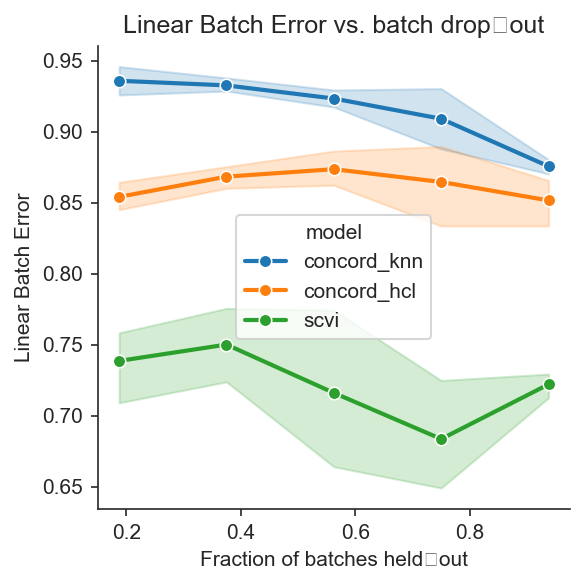

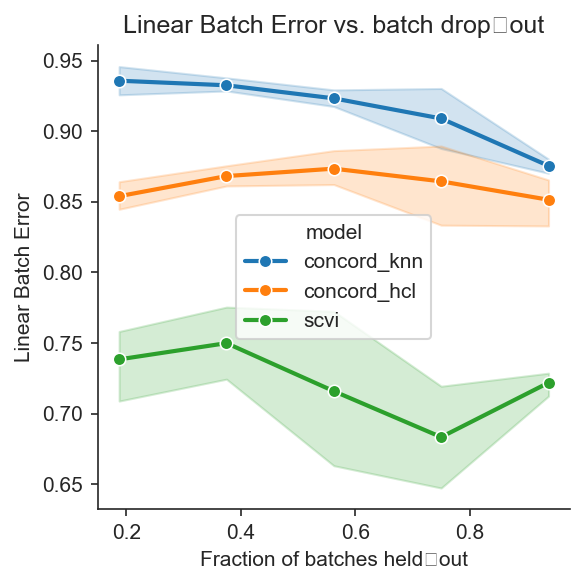

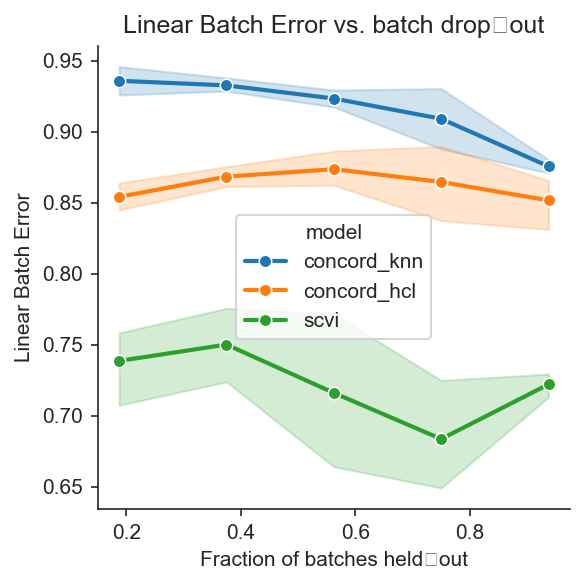

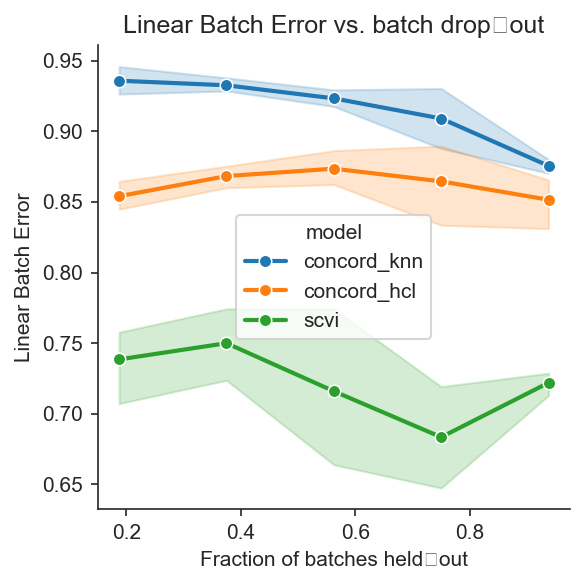

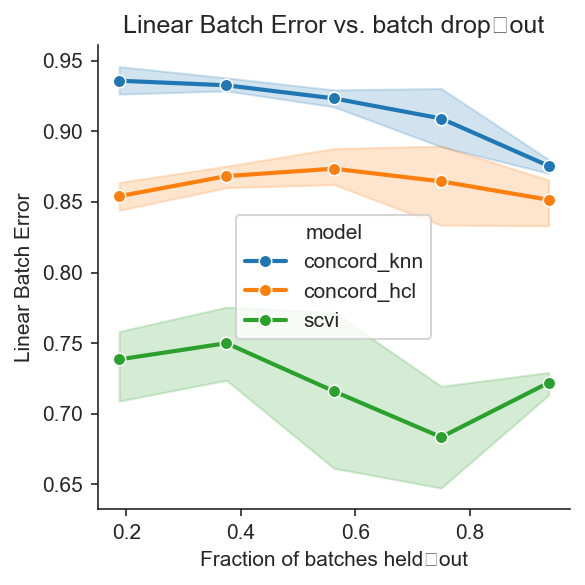

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")          # small aesthetic touch
# ------------------------------------------------------------------ #
# choose the columns you want; adjust if you renamed them differently
metrics = [
    "knn_batch_error", "knn_state_accuracy",
    "linear_batch_error", "linear_state_accuracy",
    "probe_score"
]

for metric in metrics:
    import seaborn as sns, matplotlib.pyplot as plt

    sns.set_style("ticks")
    metric = "linear_batch_error"

    plt.figure(figsize=(4,4), dpi=150)
    sns.lineplot(
        data=flat,
        x="frac_dropped", y=metric,
        hue="model",
        estimator="mean",   # or "median"
        ci=95,              # shaded ribbon
        marker="o", linewidth=2
    )

    plt.xlabel("Fraction of batches held-out")
    plt.ylabel(metric.replace("_"," ").title())
    plt.title(f"{metric.replace('_',' ').title()} vs. batch drop-out")
    sns.despine(); plt.tight_layout(); plt.show()



In [68]:
(0.78625     +    0.21375  +    0.80625     +    0.19375)/4

0.5

In [57]:
metrics

['batch_error', 'state_accuracy', 'probe_score']